In [79]:
import joypy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly_express as px
import plotly.graph_objects as go
import plotly.offline as py
import seaborn as sns
import missingno as msno
from datetime import datetime
from matplotlib import cm
from sklearn.feature_selection import SelectKBest, chi2
from feature_engine.missing_data_imputers import RandomSampleImputer
from scipy import stats
import calendar
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
#plt.rcParams['lines.linewidth'] = 2
#plt.rcParams['lines.color'] = 'g'
#plt.style.use('seaborn-white')

In [80]:
filename='KNMI.txt'
df = pd.read_csv(filename,error_bad_lines=False,header=0)
print('--->dimension of dataset')
print(df.shape)
print('--------------------------------------------------------------------------')
print('--->Preview the dataset')

print(df.sample(5))
print('--------------------------------------------------------------------------')
print('--->View summary of dataset')

df.info()
print('--------------------------------------------------------------------------')
print('--->View column names') 
df.columns

C:\Users\Gebruiker\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning:

Columns (0,2,3,4,5,6,7,8,11,12,13,14,15,16,18,19,20,21,22,23,25,26,28,30,31,32,33,34,35,36,37,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.



--->dimension of dataset
(831845, 41)
--------------------------------------------------------------------------
--->Preview the dataset
       # STN    YYYYMMDD  DDVEC  FHVEC     FG    FHX   FHXH    FHN   FHNH  \
703353   350  20050706.0    224     24     35     50      2     10     21   
746203   375  19520110.0    219    113    123    154     12     93      4   
452822   290  20171224.0    239     74     75     90      9     60     23   
353900   280  19180829.0    325     62     62     98      1     21     20   
375319   280  19770420.0    214     57     57     93     14      5      1   

          FXX  ...   VVNH    VVX   VVXH     NG     UG     UX    UXH     UN  \
703353    100  ...     23     75      1      7     88     96      6     77   
746203         ...                           7                               
452822    160  ...     11     70     17      8     91     95      7     85   
353900         ...                                 92                        
375319    

Index(['# STN', 'YYYYMMDD', 'DDVEC', 'FHVEC', '   FG', '  FHX', ' FHXH',
       '  FHN', ' FHNH', '  FXX', ' FXXH', '   TG', '   TN', '  TNH', '   TX',
       '  TXH', ' T10N', 'T10NH', '   SQ', '   SP', '    Q', '   DR', '   RH',
       '  RHX', ' RHXH', '   PG', '   PX', '  PXH', '   PN', '  PNH', '  VVN',
       ' VVNH', '  VVX', ' VVXH', '   NG', '   UG', '   UX', '  UXH', '   UN',
       '  UNH', ' EV24'],
      dtype='object')

In [81]:
del df['# STN']
#df['YYYYMMDD'] = pd.to_datetime(df['YYYYMMDD'], format='%Y%m%d')
df['YYYYMMDD'] = pd.to_datetime(df['YYYYMMDD'], format='%Y%m%d')
#df['YYYYMMDD'].dt.year
df.rename(columns = {'YYYYMMDD':'Date'}, inplace = True)  
df.columns=df.columns.str.replace(' ','')
df.drop([0],inplace=True)
#df.set_index("Date", inplace=True)
#The non-numerical(object) columns names:
numerical_columns=df.select_dtypes(exclude =[np.number]).columns

In [82]:
numerical_columns

Index(['Date', 'DDVEC', 'FHVEC', 'FG', 'FHX', 'FHXH', 'FHN', 'FHNH', 'FXX',
       'FXXH', 'TG', 'TN', 'TNH', 'TX', 'TXH', 'T10N', 'T10NH', 'SQ', 'SP',
       'Q', 'DR', 'RH', 'RHX', 'RHXH', 'PG', 'PX', 'PXH', 'PN', 'PNH', 'VVN',
       'VVNH', 'VVX', 'VVXH', 'NG', 'UG', 'UX', 'UXH', 'UN', 'UNH', 'EV24'],
      dtype='object')

In [83]:
#eliminating duplicates observations
df.drop_duplicates(subset='Date', keep='last',inplace=True)

In [84]:
#spliting date format to year , month , day
df['Year']=df['Date'].dt.year
df['Month']=df['Date'].dt.month
df['Day']=df['Date'].dt.day

In [85]:
#converting object variable to numeric variable
categorical = [var for var in df.columns if df[var].dtype=='O']
for t in categorical:
    df[t] = pd.to_numeric(df[t],errors='coerce')

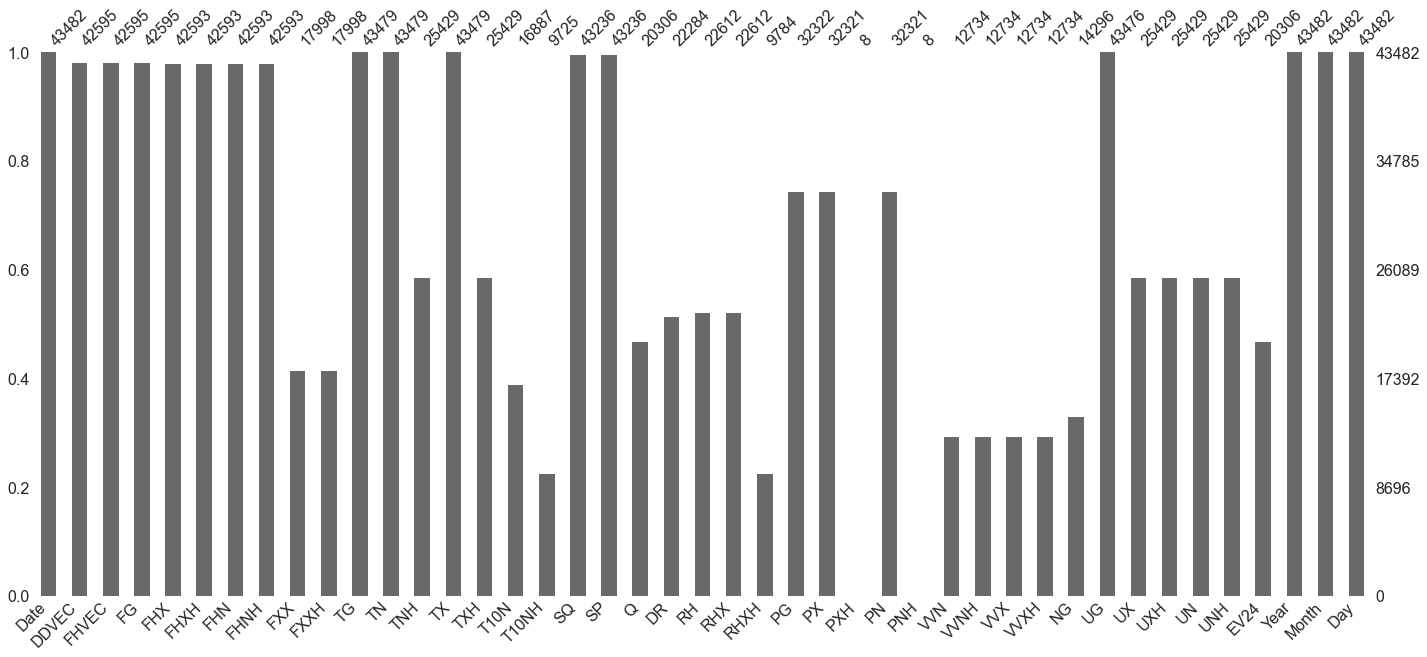

In [86]:
#missing value visualization
msno.bar(df)

In [87]:
#rescaling to Centigrad
df['TX']=df['TX']/10
df['TG']=df['TG']/10
df['SQ']=df['SQ']/10

In [88]:
#to see how its distrubution looks like, we need it to decide which method should has been taken to kill the outliers
df['TX'].skew(),df['TG'].skew(),df['SQ'].skew()

(-0.0023061232402236433, -0.1853457444024886, 0.7728443066280349)

(<matplotlib.axes._subplots.AxesSubplot at 0x268f3c01400>,
 <matplotlib.axes._subplots.AxesSubplot at 0x268f3c01400>)

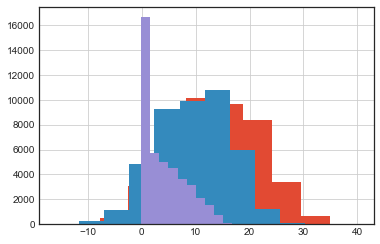

In [89]:
df['TX'].hist(),df['TG'].hist(),df['SQ'].hist()

In [90]:
# detecting outliers for a Gaussian variable

Upper_boundary = df.TX.mean() + 3* df.TX.std()
Lower_boundary = df.TX.mean() - 3* df.TX.std()
print('TX outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_boundary, upperboundary=Upper_boundary))

TX outliers are values < -9.63547827228503 or > 37.26792612067142


In [91]:
df['TX'].describe()

count    43479.000000
mean        13.816224
std          7.817234
min        -13.200000
25%          8.000000
50%         13.900000
75%         19.700000
max         40.200000
Name: TX, dtype: float64

In [92]:
df.loc[df.TX>37, 'TX'] = 37
df.loc[df.TX<-9, 'TX'] = -9

In [93]:
# detecting outliers

Upper_boundary = df.TG.mean() + 3* df.TG.std()
Lower_boundary = df.TG.mean() - 3* df.TG.std()
print('TG outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_boundary, upperboundary=Upper_boundary))

TG outliers are values < -10.245078557822545 or > 29.558066437028494


In [94]:
df['TG'].describe()

count    43479.000000
mean         9.656494
std          6.633857
min        -16.300000
25%          4.900000
50%          9.900000
75%         14.800000
max         30.300000
Name: TG, dtype: float64

In [95]:
df.loc[df.TG>29, 'TG'] = 29
df.loc[df.TG<-9, 'TG'] = -9

In [96]:
#detecting outliers 
IQR = df.SQ.quantile(0.75) - df.SQ.quantile(0.25)
Lower_fence = df.SQ.quantile(0.25) - (IQR * 3)
Upper_fence = df.SQ.quantile(0.75) + (IQR * 3)
print('SQ outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

SQ outliers are values < -19.2 or > 26.3


In [97]:
df['SQ'].describe()

count    43236.000000
mean         4.048566
std          3.966216
min         -0.100000
25%          0.300000
50%          3.000000
75%          6.800000
max         16.700000
Name: SQ, dtype: float64

In [98]:
#fortunatly SQ variable does not suffer from outlier

Text(0, 0.5, 'TG')

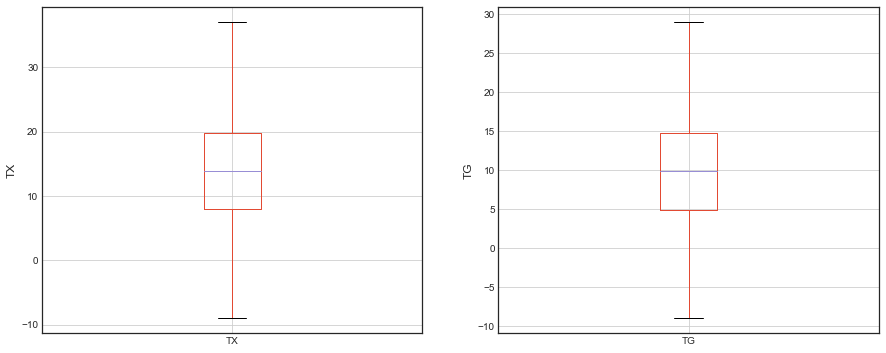

In [99]:
#to check whether outliers have been killed?
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = df.boxplot(column='TX')
fig.set_title('')
fig.set_ylabel('TX')

plt.subplot(1, 2, 2)
fig = df.boxplot(column='TG')
fig.set_title('')
fig.set_ylabel('TG')

In [100]:
df.drop(columns='Date',inplace=True)

In [101]:
cdf=df[(df['Year']!=1901) & (df['Year']!=2020)].copy()


In [102]:
#Filling missing values with median value of each variable distribution because values have not been missed in a systematic way
mdf=cdf.copy()        
#for t in categorical:
for t in mdf.columns:
    col_median=mdf[t].median()
    mdf[t]=mdf[t].fillna(col_median)

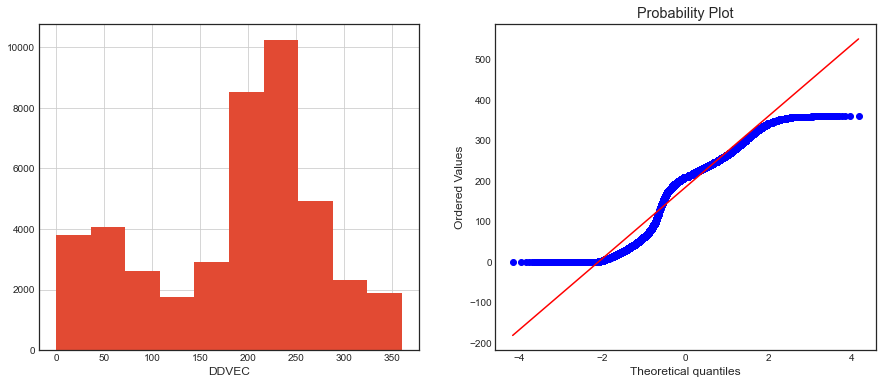

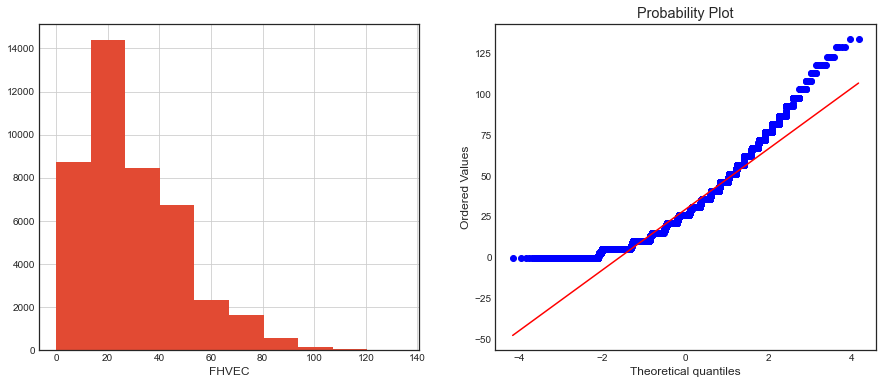

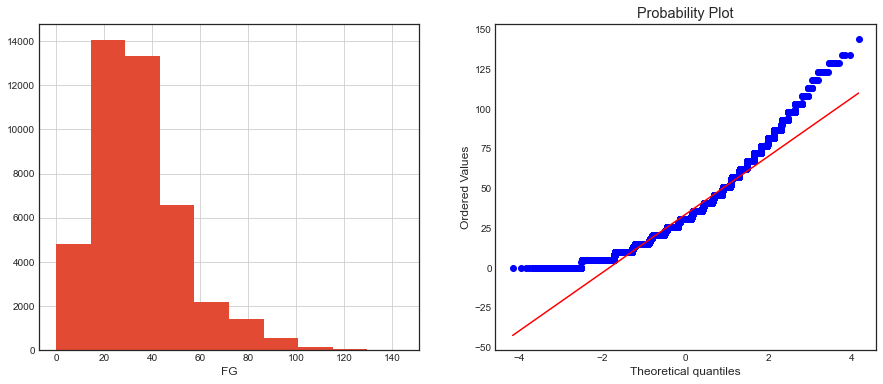

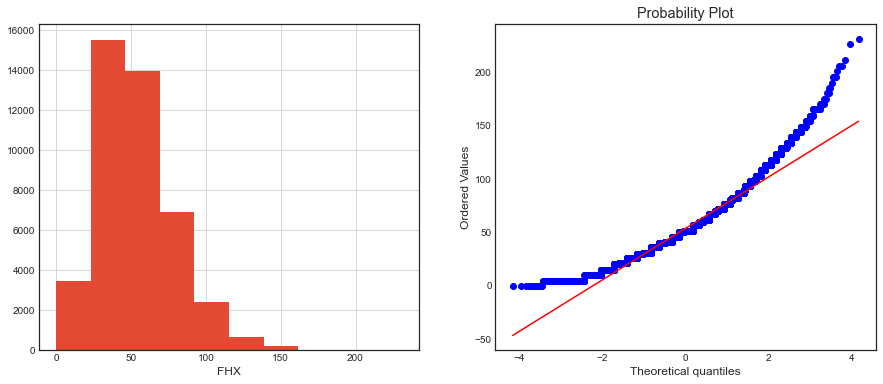

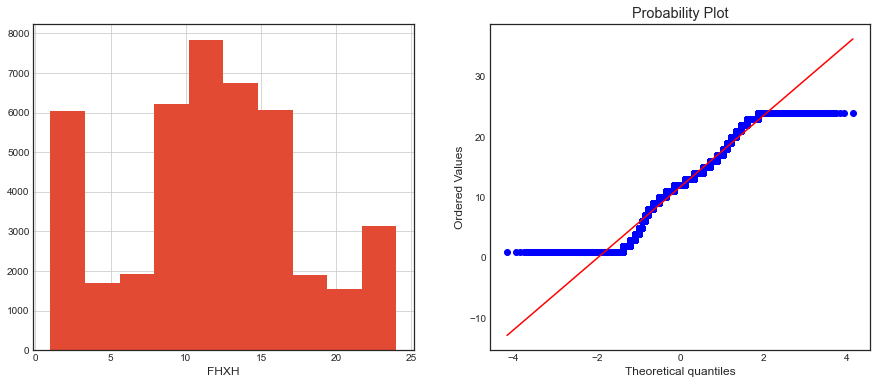

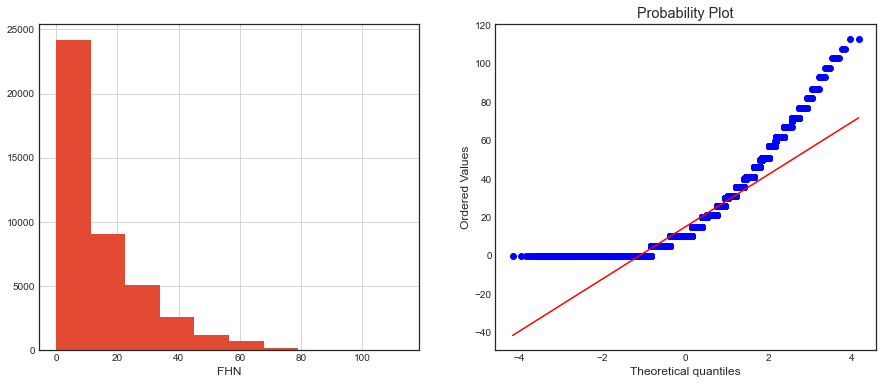

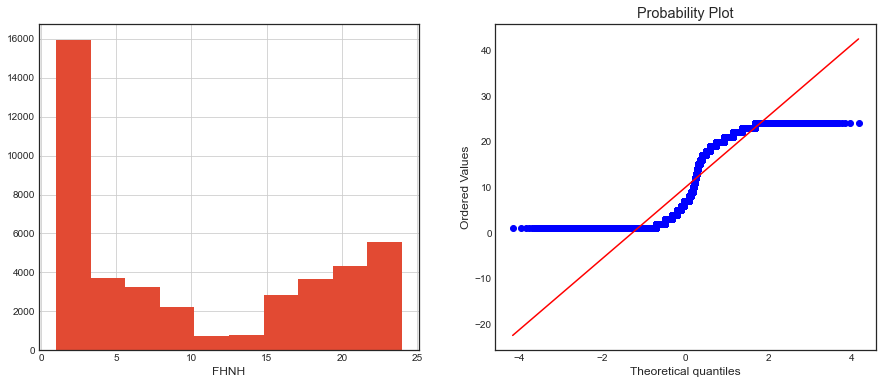

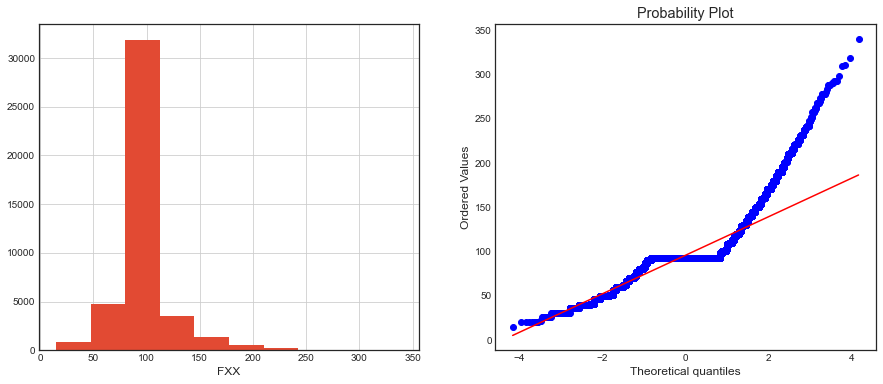

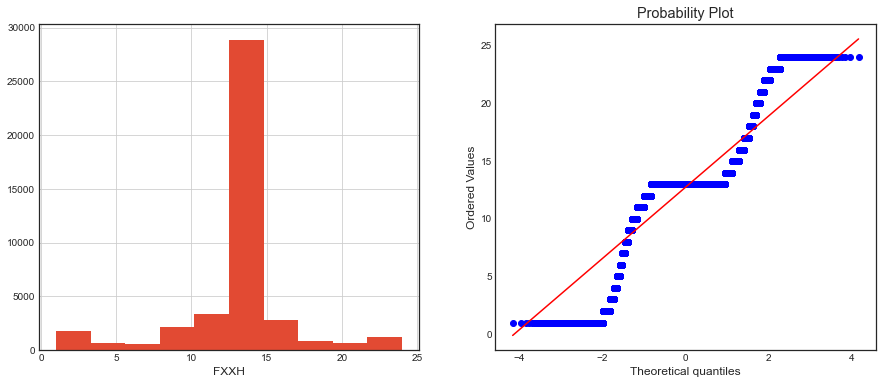

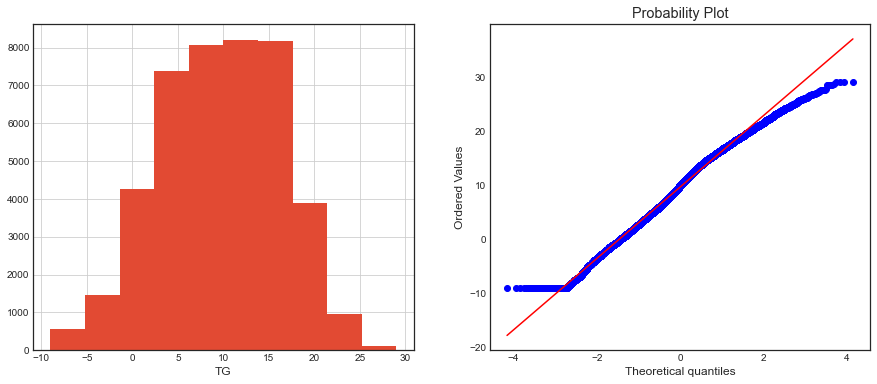

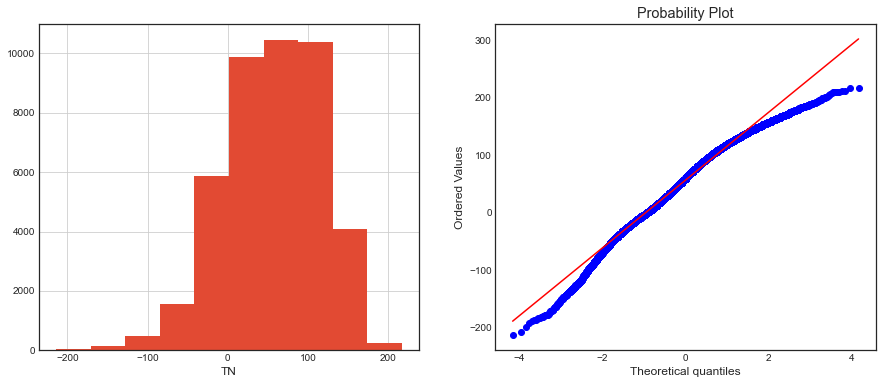

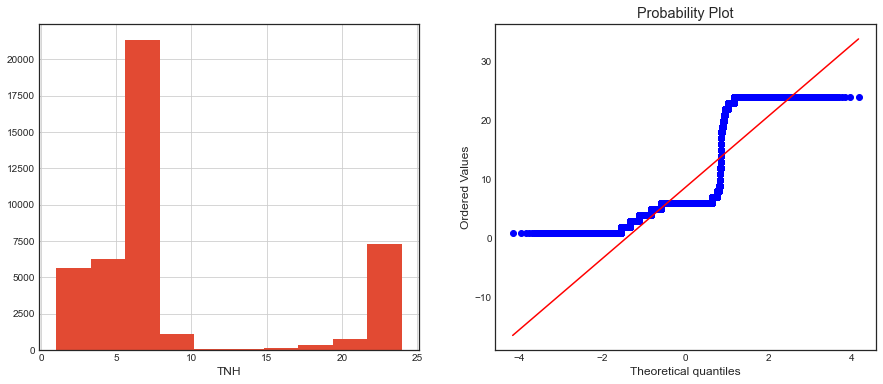

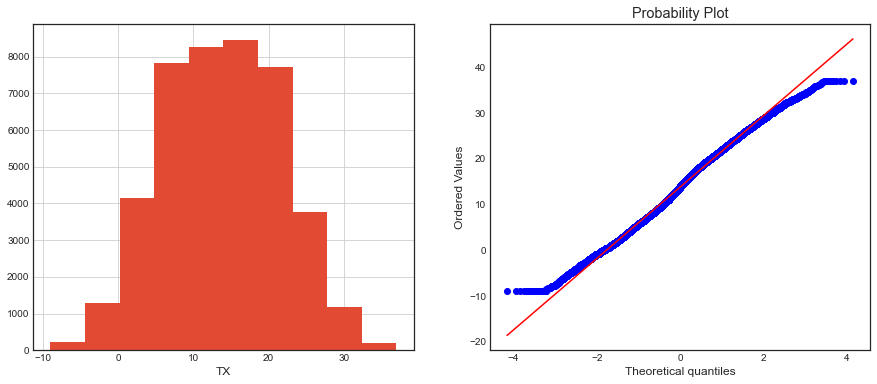

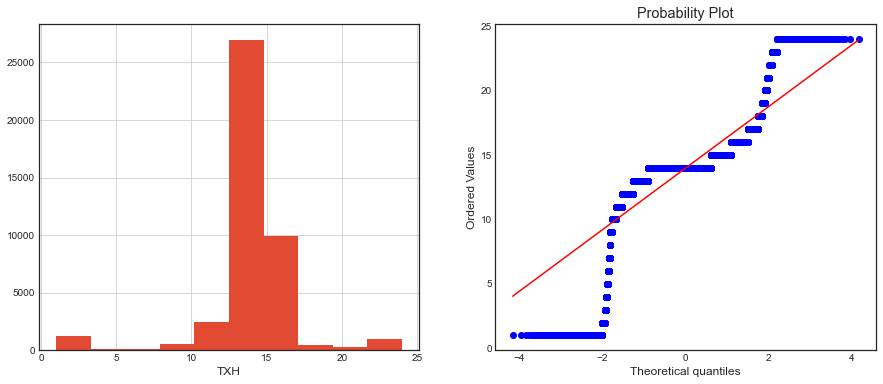

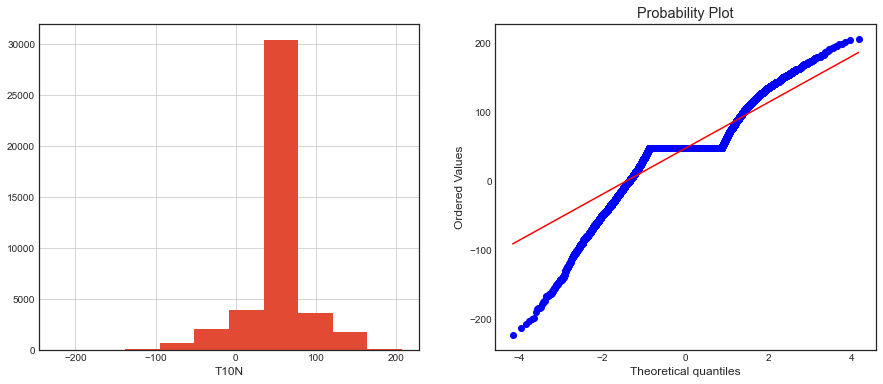

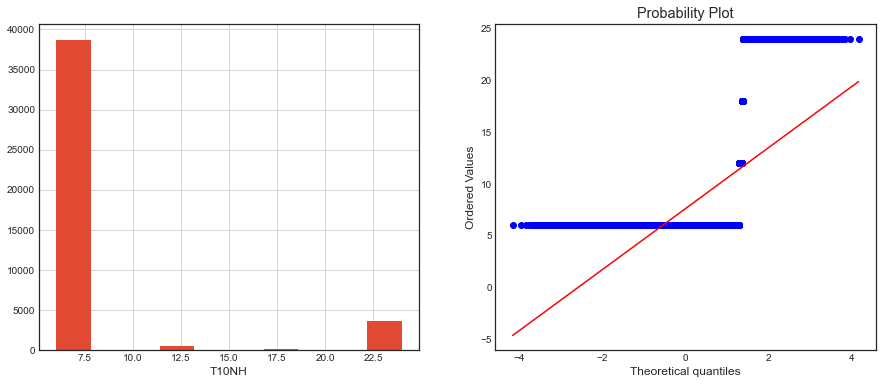

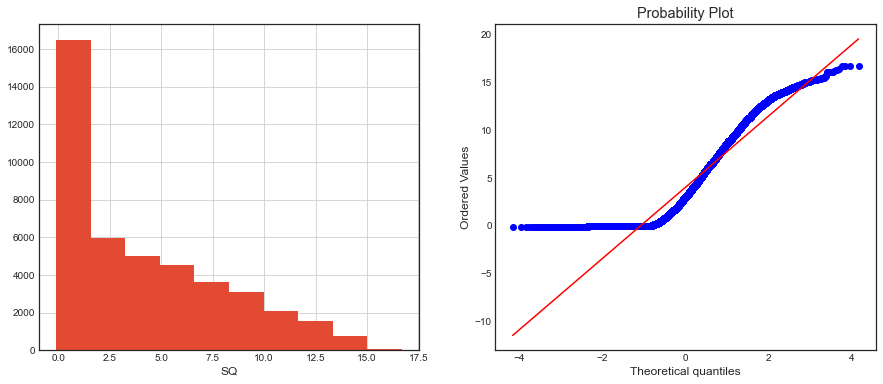

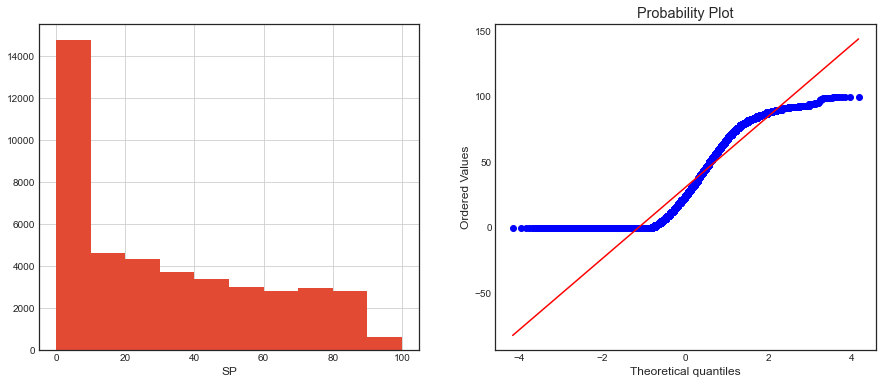

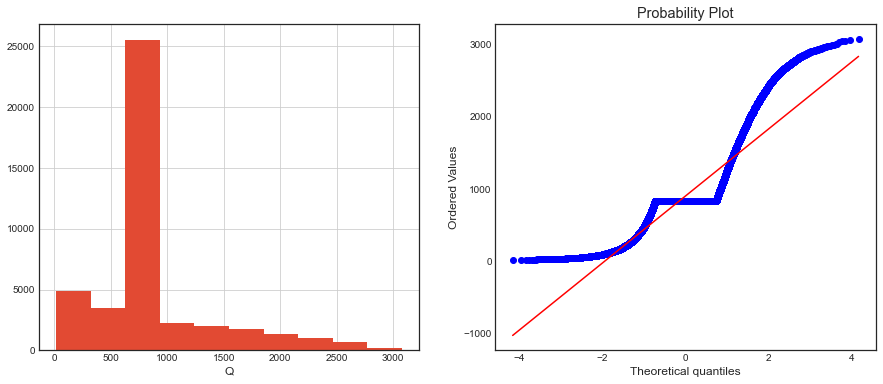

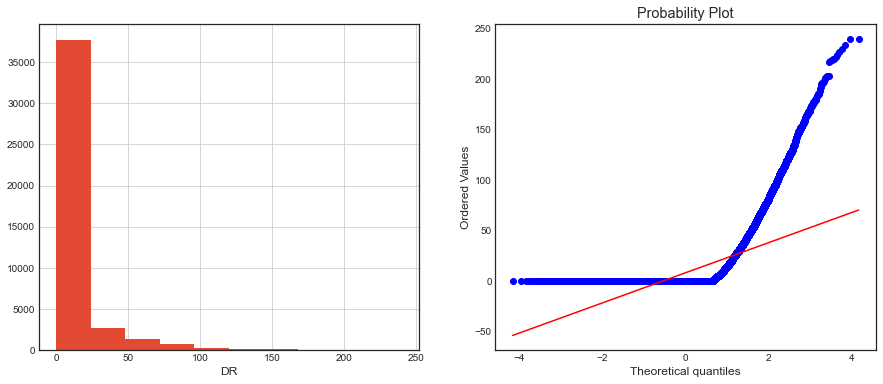

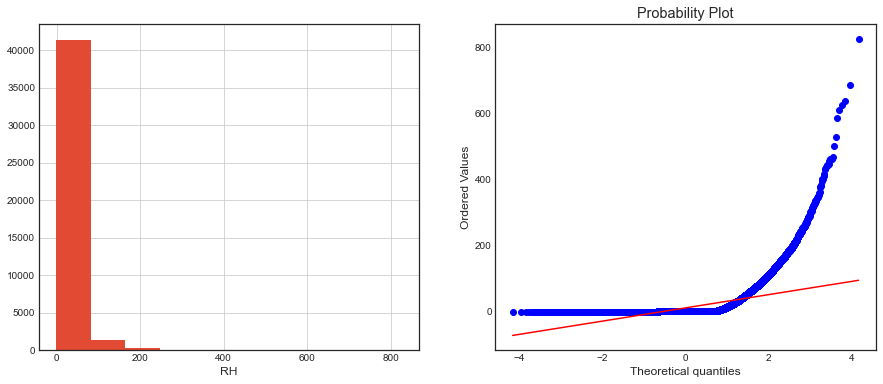

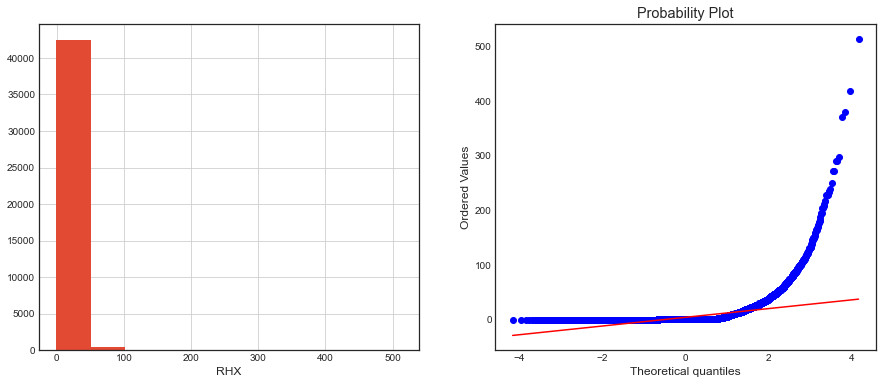

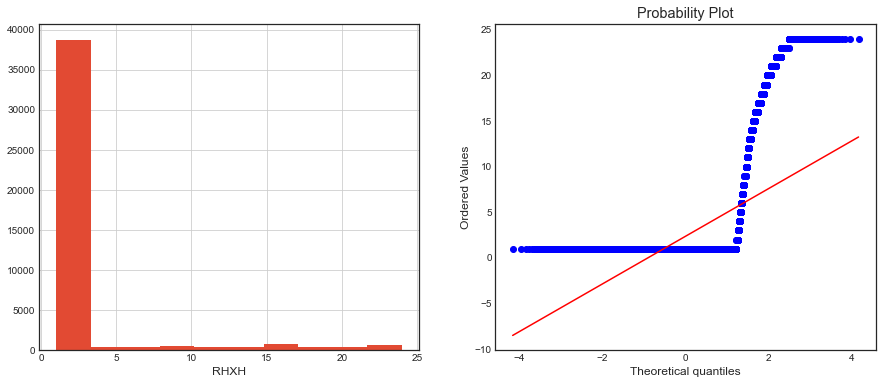

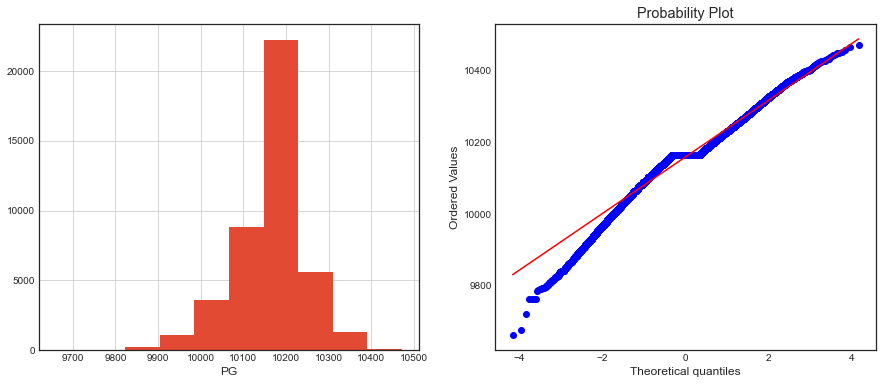

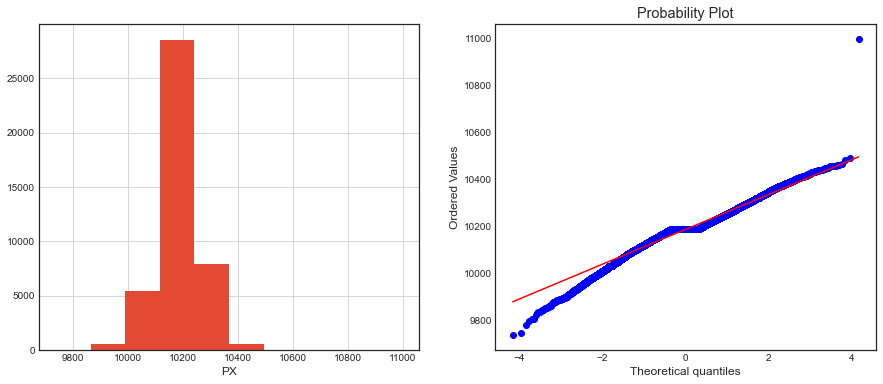

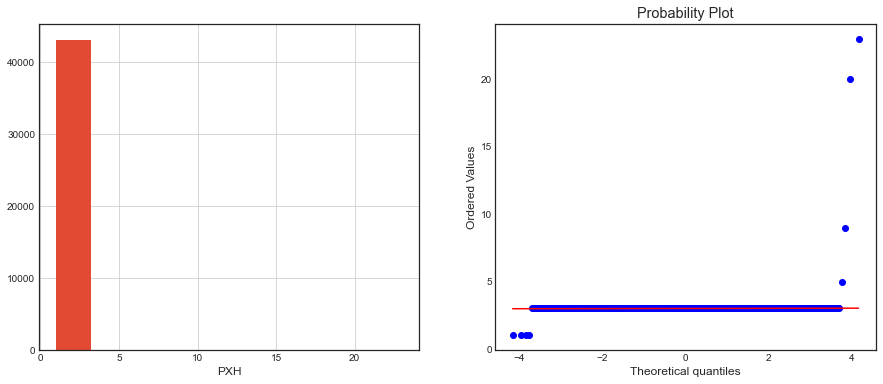

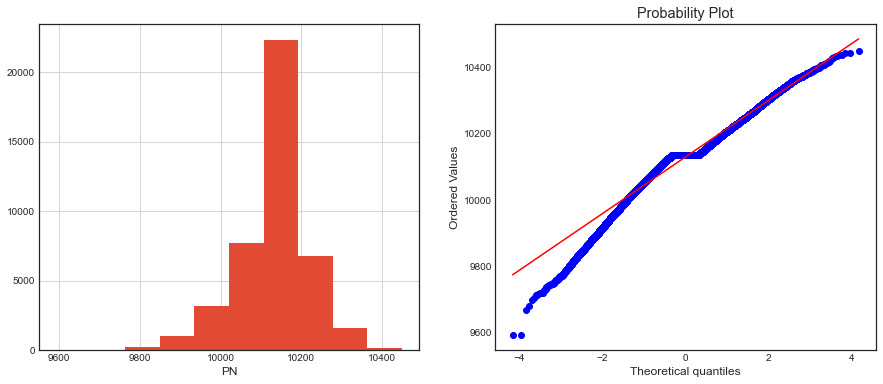

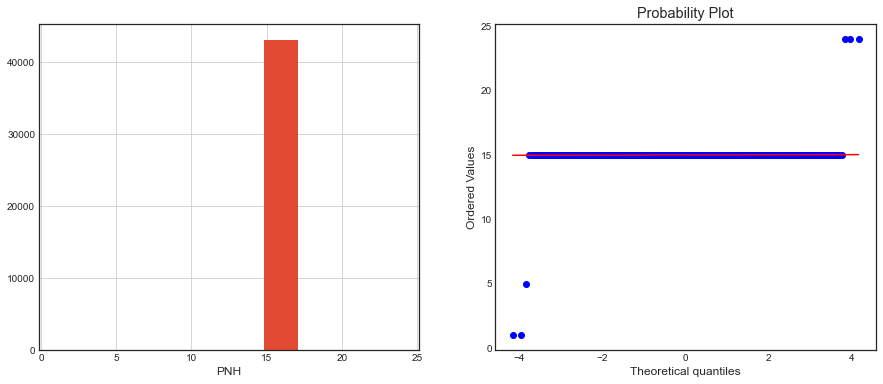

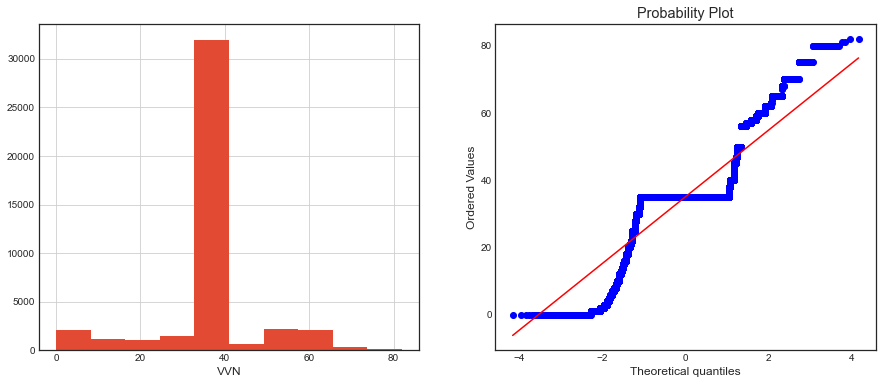

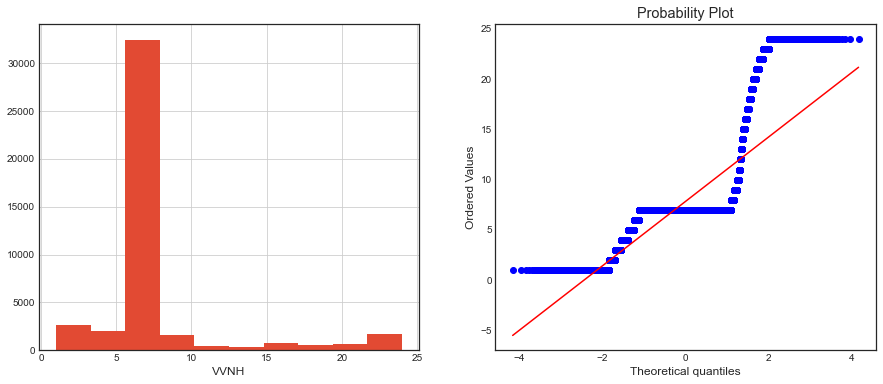

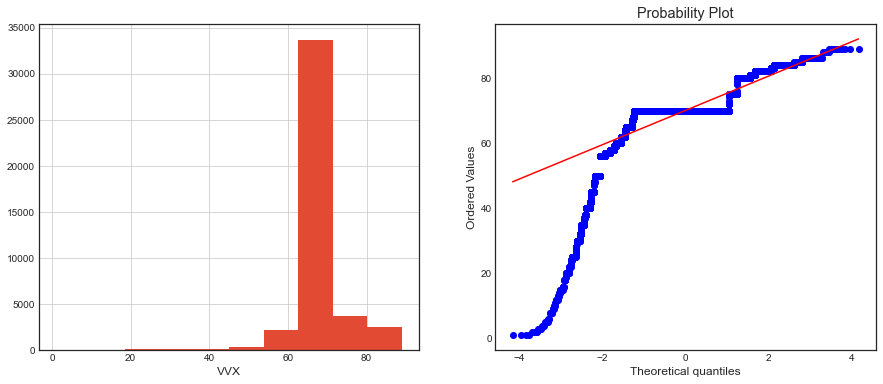

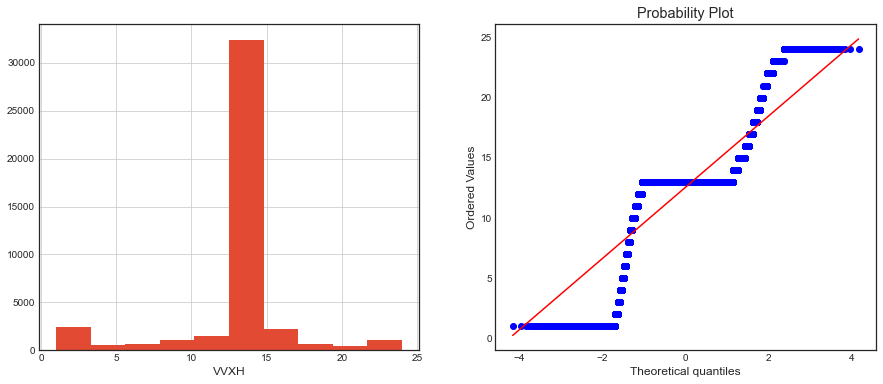

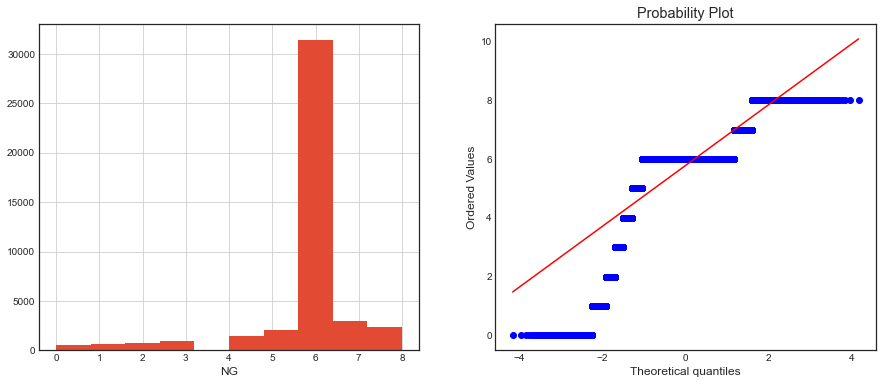

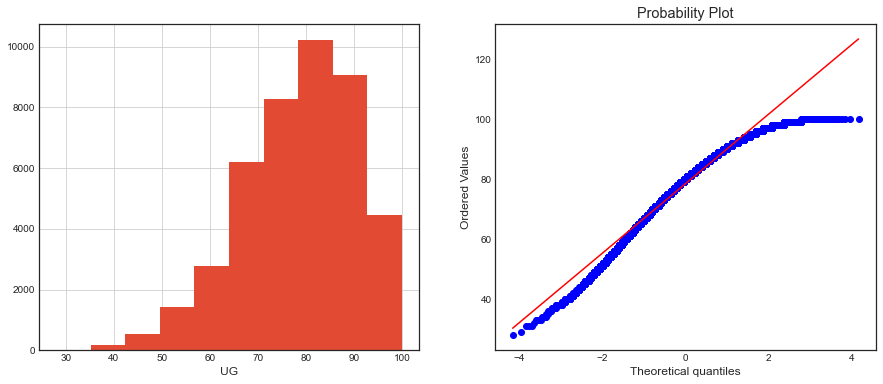

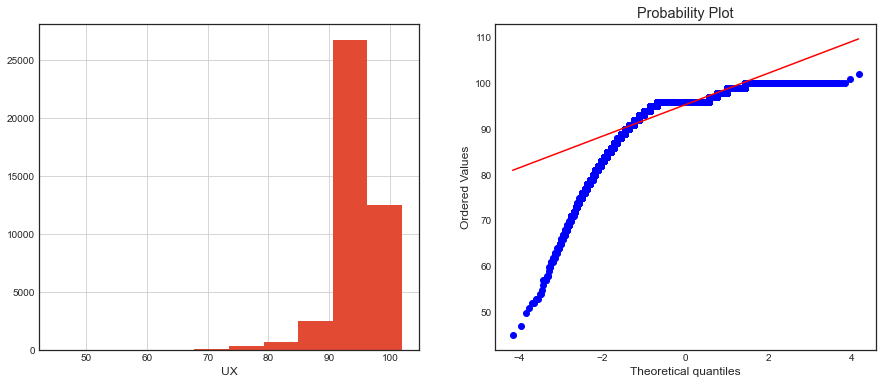

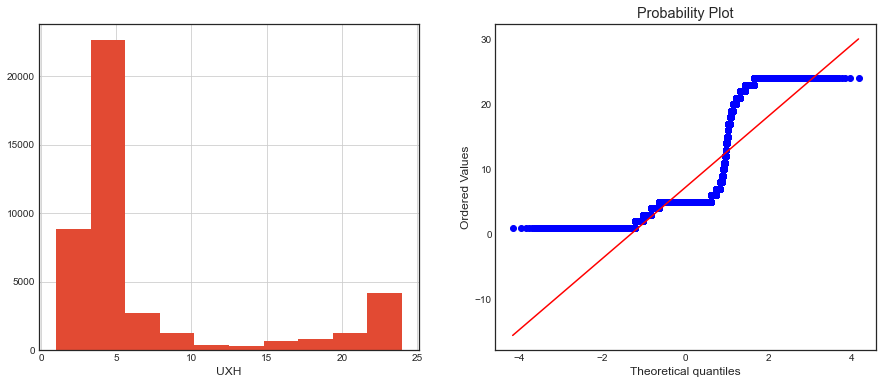

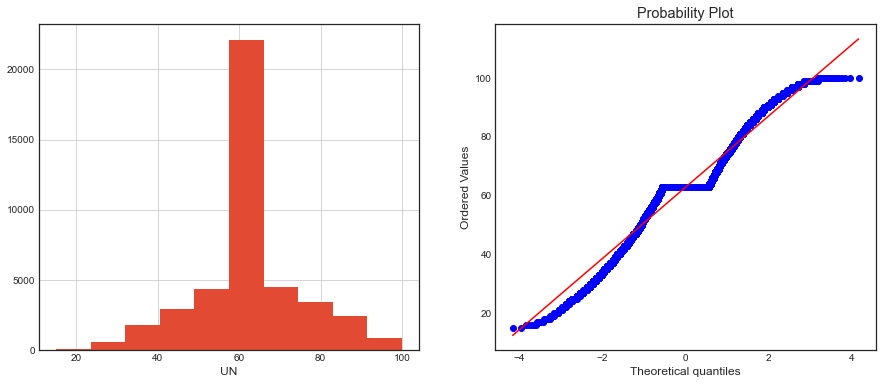

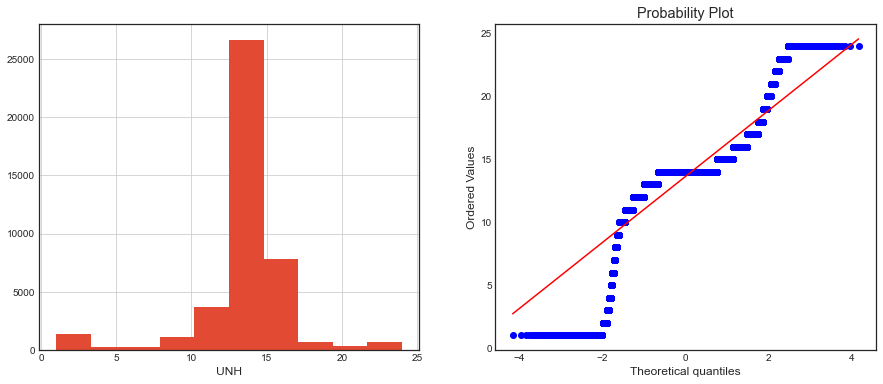

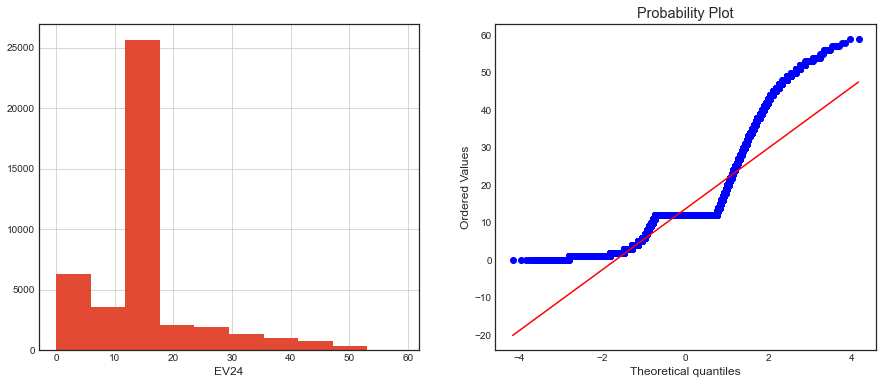

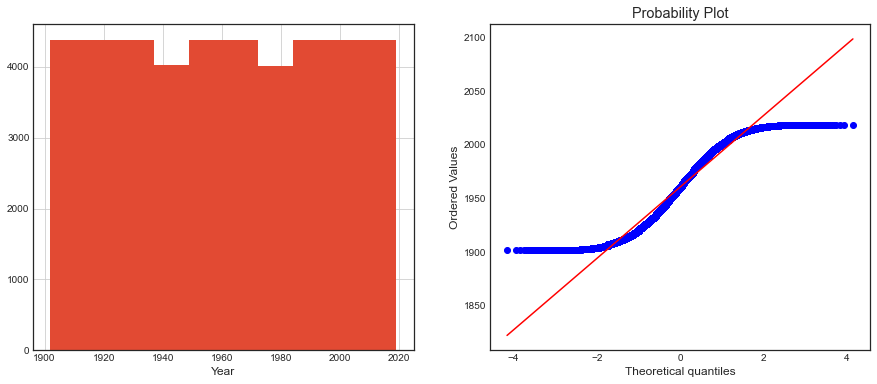

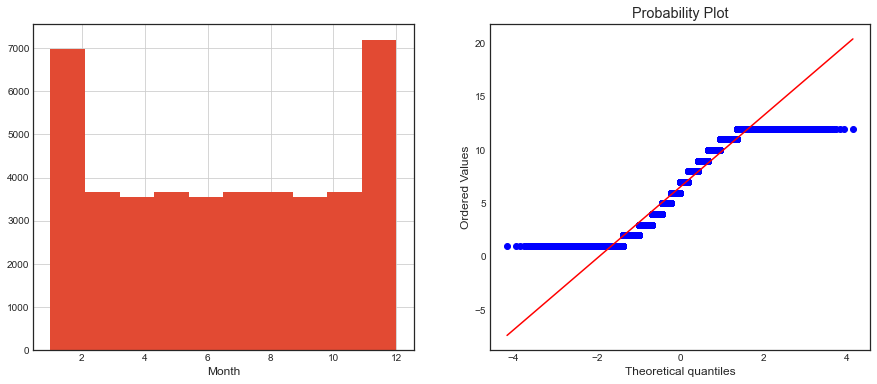

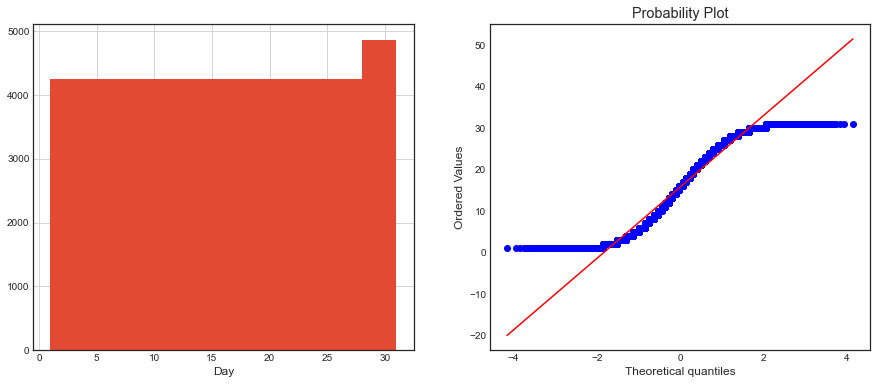

In [103]:
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.xlabel(t)

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm",plot=plt)

    plt.show()

for t in mdf.columns:
    diagnostic_plots(mdf,t)

In [104]:
#High correlation between two variables means they have similar trends and are likely to carry similar information, we would like to see what variables come up with more correlation with SQ variable
cor=df.corr()
#f , ax = plt.subplots(figsize = (14,12))
#plt.title('Correlation of Features- HeatMap',y=1,size=16)
#sns.heatmap(cor,square = True,  vmax=0.8)
cor_target = abs(cor["SQ"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.3]
print('the most relevant features are')
relevant_features

the most relevant features are


TG      0.432111
TX      0.550485
SQ      1.000000
SP      0.955909
Q       0.850213
DR      0.409033
RHXH    0.362928
PXH     0.443635
PNH     0.598785
NG      0.816428
UG      0.700290
UN      0.780866
EV24    0.818122
Name: SQ, dtype: float64

In [105]:
mdf.rename(columns = {'TX':'Maximum temperature','SQ':'Sunshine duration','TG':'24-hour average temperature' }, inplace = True)  

In [106]:
mdf[['24-hour average temperature','Sunshine duration','Year','Month']].to_csv('clean.csv')

In [107]:
#mdf.to_csv('clean.csv')

In [108]:
ss=np.array([])
for i in range(12):
    for j in range (31):
        cc=mdf[mdf['Month']==i+1][df['Day']==j+1]['Sunshine duration'].mean()
        ss=np.append(ss,cc)

<ipython-input-108-c56aa33dd473>:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [109]:
ssf=pd.DataFrame(ss,columns=['Average sunshine duration'])


In [110]:
ssf.dropna(inplace=True)

In [111]:
#for t in ssf.columns:
#    col_mean=ssf[t].mean()
#    ssf[t]=ssf[t].fillna(col_mean)

In [112]:
tt=np.array([])
for i in range(12):
    for j in range (31):
        c=mdf[mdf['Month']==i+1][df['Day']==j+1]['24-hour average temperature'].mean()
        tt=np.append(tt,c)

<ipython-input-112-29e128caa6e4>:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [113]:
ttf=pd.DataFrame(tt,columns=['Average mean daily temperature'])


In [114]:
ttf.dropna(inplace=True)

In [115]:
#for t in ttf.columns:
#    col_mean=ttf[t].mean()
#    ttf[t]=ttf[t].fillna(col_mean)

In [116]:
def func(t ,a, b,c):
    return a * np.sin((2*np.pi*t/366)+b)+c 
popt, pcov = curve_fit(func, np.arange(366), ttf['Average mean daily temperature'])

def ffunc(t ,a, b,c):
    return a * np.sin((2*np.pi*t/366)+b)+c 
ppopt, ppcov = curve_fit(func, np.arange(366), ssf['Average sunshine duration'])

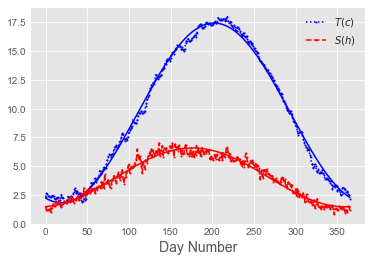

In [117]:
plt.style.use('ggplot')  
plt.plot(np.arange(366), func(np.arange(366), *popt), 'b-')
      
plt.plot(np.arange(366), ffunc(np.arange(366), *ppopt), 'r-')
         
plt.plot(np.arange(366),ttf, marker='o', linestyle=':', color='b',markersize=1,label="$T(c)$")
plt.plot(np.arange(366),ssf, marker='o', linestyle='--', color='r',markersize=1,label="$S(h)$")
plt.legend()
plt.xlabel("Day Number",fontsize=14)
plt.savefig('222.jpeg',
            format='jpeg',
            dpi=700,
            bbox_inches='tight')

plt.show()




In [118]:
def vunc(t ,a, b,c):
    return (2*np.pi*t/366) * a * np.cos((2*np.pi*t/366)+b)
vopt, vcov = curve_fit(func, np.arange(366), ttf['Average mean daily temperature'])

def vvunc(t ,a, b,c):
    return (2*np.pi*t/366) * a * np.cos((2*np.pi*t/366)+b)
vvopt, vvcov = curve_fit(func, np.arange(366), ssf['Average sunshine duration'])

No handles with labels found to put in legend.


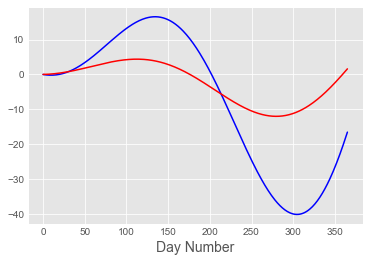

In [119]:
plt.style.use('ggplot')  
plt.plot(np.arange(366), vunc(np.arange(366), *popt), 'b-')
      
plt.plot(np.arange(366), vvunc(np.arange(366), *ppopt), 'r-')
         

plt.legend()
plt.xlabel("Day Number",fontsize=14)
plt.savefig('v222.jpeg',
            format='jpeg',
            dpi=700,
            bbox_inches='tight')

plt.show()


No handles with labels found to put in legend.


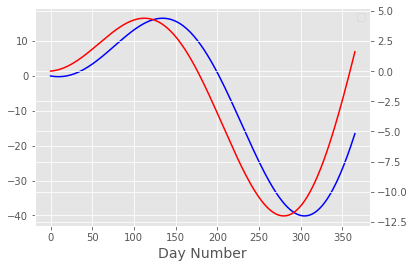

In [43]:

#specs={'markersize':8,'markerfacecolor':'w','linewidth':1}
fig,ax = plt.subplots()
ax.plot(np.arange(366), vunc(np.arange(366), *popt), 'b-')
ax.legend()
#ax.set_ylabel("$T(c)$",color="red",fontsize=14)
ax.set_xlabel("Day Number",fontsize=14)
ax2=ax.twinx()
ax2.plot(np.arange(366), vvunc(np.arange(366), *ppopt), 'r-')
#ax2.set_ylabel("$S(h)$",color="red",fontsize=14)

#ax2.yaxis.set_major_formatter(FormatStrFormatter('?%1.2f'))
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax.legend(lines, labels, loc=0)



plt.show()
# save the plot as a file
fig.savefig('222.pdf',
            format='pdf',
            dpi=100,
            bbox_inches='tight')



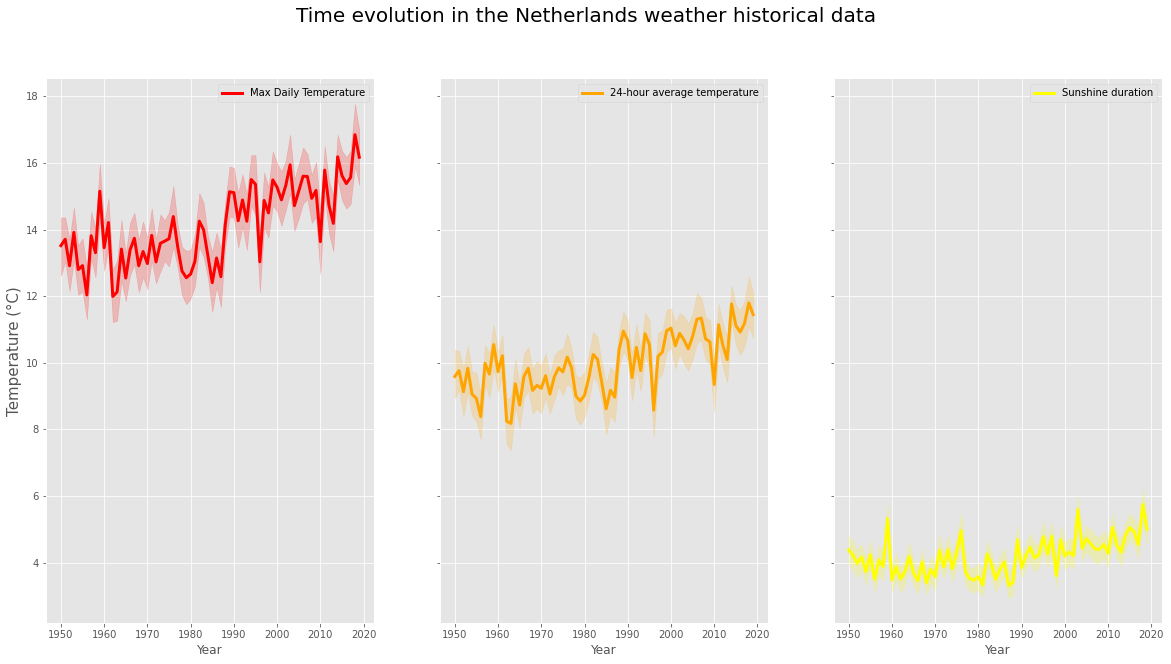

In [44]:

fig, axs = plt.subplots(1, 3, figsize=(20, 10), sharey=True)
sns.lineplot(
    x="Year",
    y="Maximum temperature",
    linewidth=3,
    data=mdf[mdf['Year']>=1950],
    label="Max Daily Temperature",
    color="red",
    ax=axs[0],
)
sns.lineplot(
    x="Year",
    y="24-hour average temperature",
    linewidth=3,
    data=mdf[mdf['Year']>=1950],
    label="24-hour average temperature",
    color="orange",
    ax=axs[1],
)
sns.lineplot(
    x="Year",
    y="Sunshine duration",
    linewidth=3,
    data=mdf[mdf['Year']>=1950],
    label="Sunshine duration",
    color="yellow",
    ax=axs[2],
)
fig.suptitle("Time evolution in the Netherlands weather historical data", fontsize=20)
axs[0].set_ylabel("Temperature (°C)", fontsize=15)
sns.despine()
plt.show()

In [45]:
#a = mdf.groupby("Month")['Sunshine duration'].mean()
#b= mdf.groupby("Month")["24-hour average temperature"].mean()
#con = pd.concat([a, b], axis=1)
#con.reset_index(inplace=True)

In [46]:
#plt.plot(con['Month'],coef,'bo-')
#plt.plot(con['Month'],pval,'ro--')

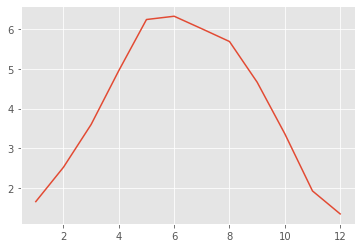

In [47]:
a = mdf.groupby("Month")["24-hour average temperature"].mean()
b= mdf.groupby("Month")["Sunshine duration"].mean()
con = pd.concat([a, b], axis=1)
con.reset_index(inplace=True)
plt.plot(con['Month'],con['Sunshine duration'])
# as we except sun duration during summer months are in its maximum value

In [127]:
def ffunc(j):
    
    pval=np.array([])
    coef=np.array([])
    for i in range(12):
        cor,pes=stats.pearsonr(mdf[mdf['Year']<1986][mdf['Year']>1957+j][mdf['Month']==i+1]['Sunshine duration'], mdf[mdf['Year']<1986][mdf['Year']>1957+j][mdf['Month']==i+1]['24-hour average temperature'])
        pval=np.append(pval,pes)
        coef=np.append(coef,cor)
    return pval,coef    

In [128]:
ffunc(0)

<ipython-input-127-270b27ae8cd2>:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



(array([5.01057088e-15, 9.07624740e-06, 9.58835579e-01, 1.25292933e-15,
        2.42366102e-38, 8.38964037e-45, 1.66663248e-77, 1.72277062e-43,
        1.11130256e-09, 3.51325533e-02, 1.01762249e-01, 1.14780123e-19]),
 array([-0.26139806, -0.15706811, -0.00175445,  0.27121118,  0.41962741,
         0.45806492,  0.57489322,  0.44522936,  0.20821471,  0.07152185,
        -0.05649915, -0.30124155]))

In [129]:
def func(j):
    
    pval=np.array([])
    coef=np.array([])
    for i in range(12):
        cor,pes=stats.pearsonr(mdf[mdf['Year']<2013][mdf['Year']>1985+j][mdf['Month']==i+1]['Sunshine duration'], mdf[mdf['Year']<2013][mdf['Year']>1985+j][mdf['Month']==i+1]['24-hour average temperature'])
        pval=np.append(pval,pes)
        coef=np.append(coef,cor)
    return pval,coef     

In [130]:
func(0)[1]

<ipython-input-129-8962919c31a0>:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



array([-0.30640292, -0.19610121, -0.05201502,  0.22717162,  0.46166269,
        0.48819367,  0.5358562 ,  0.41471911,  0.15523926, -0.13731866,
       -0.17694694, -0.33889783])

<ipython-input-65-8962919c31a0>:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-48-be7a5ed57a58>:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



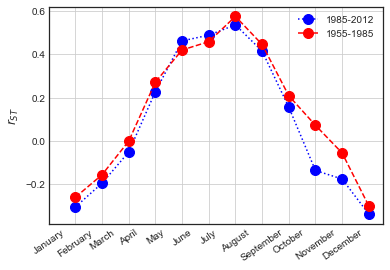

In [67]:
plt.style.use('seaborn-white')
plt.plot(con['Month'],func(0)[1],'bo:',markersize=10,label='1985-2012')
plt.plot(con['Month'],ffunc(0)[1],'ro--',markersize=10,label='1955-1985')
plt.xticks(np.arange(12), calendar.month_name[1:13], rotation=35)
plt.legend()
plt.ylabel('$r_{ST}$')
plt.grid()
plt.savefig("co.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)
plt.show()


<ipython-input-65-8962919c31a0>:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-48-be7a5ed57a58>:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



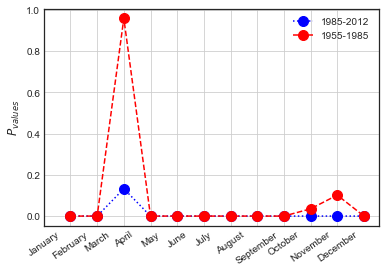

In [68]:

plt.plot(con['Month'],func(0)[0],'bo:',markersize=10,label='1985-2012')
plt.plot(con['Month'],ffunc(0)[0],'ro--',markersize=10,label='1955-1985')
#plt.plot(con['Month'],np.full((1,12),0.005).reshape(-1,1),'ro--',label='p-values')
plt.xticks(np.arange(12), calendar.month_name[1:13], rotation=35)
#plt.ylim(0,0.02)
plt.ylabel('$P_{values}$')
plt.legend()
plt.grid()
plt.savefig("cop.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)
plt.show()


In [69]:
c=0
for j in range(27):
    c=c+func(j)[1]
cmean=c/34   
p=0
for j in range(27):
    p=p+func(j)[0]
pmean=p/34  

<ipython-input-65-8962919c31a0>:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [70]:
c1=0
for j in range(27):
    c1=c1+ffunc(j)[1]
cmean1=c1/34   
p1=0
for j in range(27):
    p1=p1+ffunc(j)[0]
pmean1=p1/34  

<ipython-input-48-be7a5ed57a58>:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



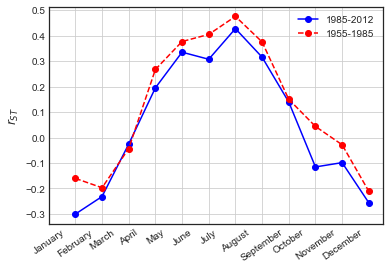

<Figure size 432x288 with 0 Axes>

In [71]:
plt.plot(con['Month'],cmean,'bo-',label='1985-2012')
plt.plot(con['Month'],cmean1,'ro--',label='1955-1985')
plt.xticks(np.arange(12), calendar.month_name[1:13], rotation=35)
plt.legend()
plt.ylabel('$r_{ST}$')
plt.grid()
plt.show()
plt.savefig("T.jpeg",bbox_inches="tight",pad_inches = 0)

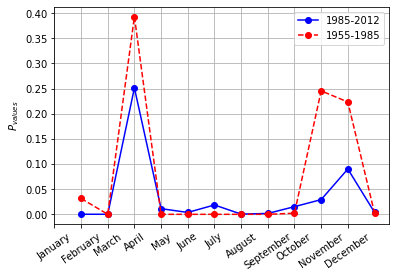

<Figure size 432x288 with 0 Axes>

In [38]:
plt.plot(con['Month'],pmean,'bo-',label='1985-2012')
plt.plot(con['Month'],pmean1,'ro--',label='1955-1985')
plt.xticks(np.arange(12), calendar.month_name[1:13], rotation=35)
#plt.ylim(0.0001,0.002)
plt.ylabel('$P_{values}$')
plt.legend()
plt.grid()
plt.show()
plt.savefig("Tp.jpeg",bbox_inches="tight",pad_inches = 0)

In [364]:
def st(j):
    s1=np.array([])
    s2=np.array([])
    for i in range(12):
        s=(np.sum(mdf[mdf['Year']>1954][mdf['Year']<2007][mdf['Month']==i+1]['24-hour average temperature']))/(51*12)-(np.sum(mdf[mdf['Year']<1954][mdf['Year']>1900+j][mdf['Month']==i+1]['24-hour average temperature']))/(51*12)
        ss=(np.sum(mdf[mdf['Year']>1954][mdf['Year']<2007][mdf['Month']==i+1]['Sunshine duration']))/(51*12)-(np.sum(mdf[mdf['Year']<1954][mdf['Year']>1900+j][mdf['Month']==i+1]['Sunshine duration']))/(51*12)
        s1=np.append(s1,s)
        s2=np.append(s2,ss)
    return s1,s2   

<ipython-input-364-1545bacf2b44>:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-364-1545bacf2b44>:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-364-1545bacf2b44>:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-364-1545bacf2b44>:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



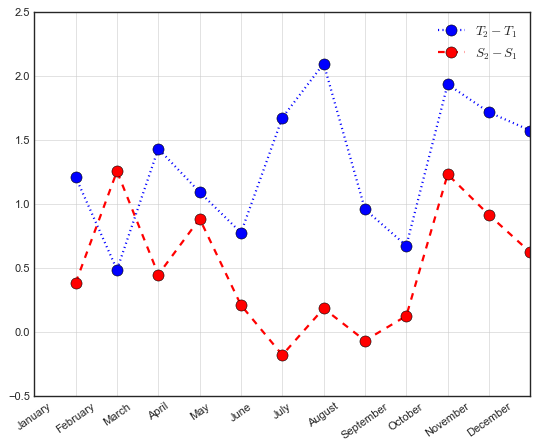

In [365]:
#plt.figure(figsize=(6, 4))
#plt.style.use('ggplot')
plt.plot(con['Month'],st(j=0)[0],'bo:',markersize=10,label='$T_{2}-T_{1}$')
plt.plot(con['Month'],st(j=0)[1],'ro--',markersize=10,label='$S_{2}-S_{1}$')
plt.xticks(np.arange(12), calendar.month_name[1:13], rotation=35)
plt.legend()
#plt.ylabel('$r_{ST}$')
plt.grid()
plt.savefig("TS.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)
plt.show()

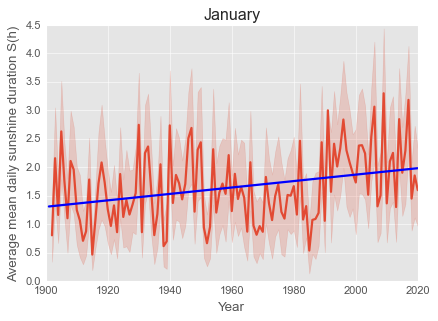

In [258]:
plt.figure(figsize=(6, 4))
#plt.style.use('ggplot')classic
plt.style.use('ggplot')
chart = sns.lineplot(x="Year", y="Sunshine duration", data=mdf[mdf['Month']==1], 
                      markers=True)
chart.set(title='January', ylabel='Average mean daily sunshine duration S(h)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==1]['Year'], mdf[mdf['Month']==1]['Sunshine duration'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("s1.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

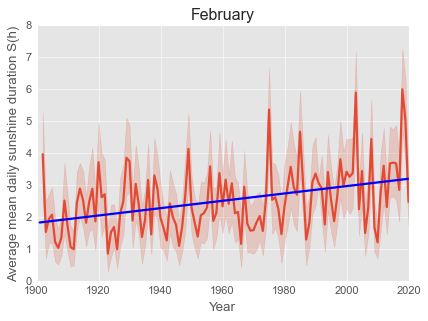

In [233]:
plt.figure(figsize=(6, 4))


chart = sns.lineplot(x="Year", y="Sunshine duration", data=mdf[mdf['Month']==2], 
                      markers=True)
chart.set(title='February', ylabel='Average mean daily sunshine duration S(h)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==2]['Year'], mdf[mdf['Month']==2]['Sunshine duration'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("s2.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

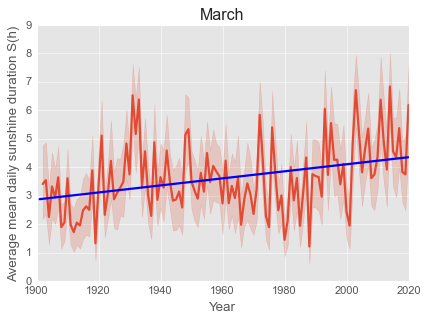

In [234]:
plt.figure(figsize=(6, 4))


chart = sns.lineplot(x="Year", y="Sunshine duration", data=mdf[mdf['Month']==3], 
                      markers=True)
chart.set(title='March', ylabel='Average mean daily sunshine duration S(h)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==3]['Year'], mdf[mdf['Month']==3]['Sunshine duration'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("s3.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

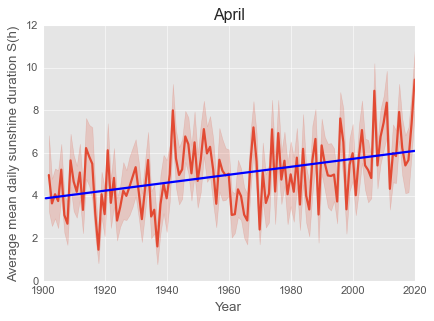

In [235]:
plt.figure(figsize=(6, 4))


chart = sns.lineplot(x="Year", y="Sunshine duration", data=mdf[mdf['Month']==4], 
                      markers=True)
chart.set(title='April', ylabel='Average mean daily sunshine duration S(h)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==4]['Year'], mdf[mdf['Month']==4]['Sunshine duration'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("s4.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

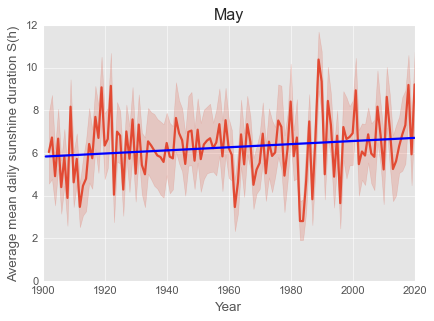

In [236]:
plt.figure(figsize=(6, 4))


chart = sns.lineplot(x="Year", y="Sunshine duration", data=mdf[mdf['Month']==5], 
                      markers=True)
chart.set(title='May', ylabel='Average mean daily sunshine duration S(h)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==5]['Year'], mdf[mdf['Month']==5]['Sunshine duration'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("s5.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

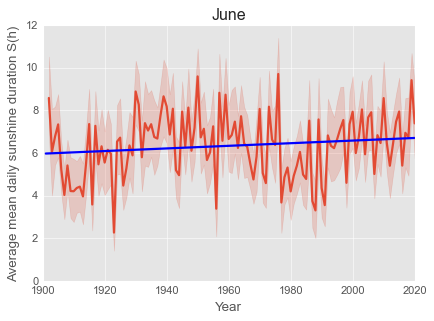

In [237]:
plt.figure(figsize=(6, 4))


chart = sns.lineplot(x="Year", y="Sunshine duration", data=mdf[mdf['Month']==6], 
                      markers=True)
chart.set(title='June', ylabel='Average mean daily sunshine duration S(h)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==6]['Year'], mdf[mdf['Month']==6]['Sunshine duration'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("s6.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

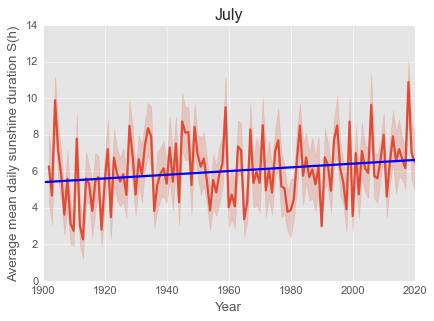

In [238]:
plt.figure(figsize=(6, 4))


chart = sns.lineplot(x="Year", y="Sunshine duration", data=mdf[mdf['Month']==7], 
                      markers=True)
chart.set(title='July', ylabel='Average mean daily sunshine duration S(h)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==7]['Year'], mdf[mdf['Month']==7]['Sunshine duration'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("s7.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

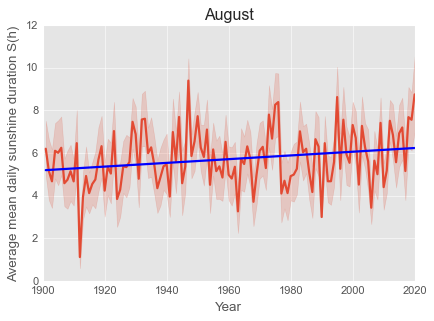

In [239]:
plt.figure(figsize=(6, 4))


chart = sns.lineplot(x="Year", y="Sunshine duration", data=mdf[mdf['Month']==8], 
                      markers=True)
chart.set(title='August', ylabel='Average mean daily sunshine duration S(h)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==8]['Year'], mdf[mdf['Month']==8]['Sunshine duration'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("s8.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

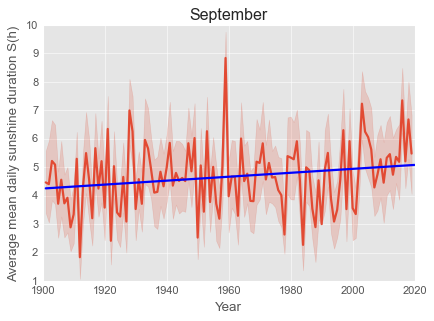

In [240]:
plt.figure(figsize=(6, 4))


chart = sns.lineplot(x="Year", y="Sunshine duration", data=mdf[mdf['Month']==9], 
                      markers=True)
chart.set(title='September', ylabel='Average mean daily sunshine duration S(h)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==9]['Year'], mdf[mdf['Month']==9]['Sunshine duration'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("s9.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

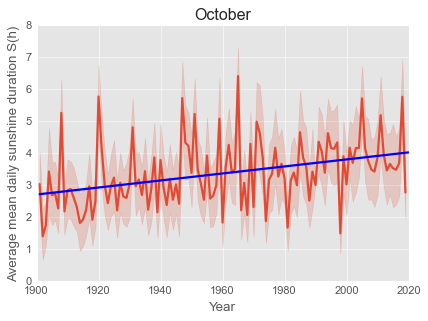

In [241]:
plt.figure(figsize=(6, 4))


chart = sns.lineplot(x="Year", y="Sunshine duration", data=mdf[mdf['Month']==10], 
                      markers=True)
chart.set(title='October', ylabel='Average mean daily sunshine duration S(h)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==10]['Year'], mdf[mdf['Month']==10]['Sunshine duration'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("s10.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

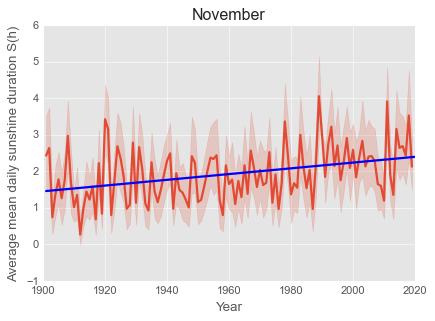

In [242]:
plt.figure(figsize=(6, 4))


chart = sns.lineplot(x="Year", y="Sunshine duration", data=mdf[mdf['Month']==11], 
                      markers=True)
chart.set(title='November', ylabel='Average mean daily sunshine duration S(h)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==11]['Year'], mdf[mdf['Month']==11]['Sunshine duration'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("s11.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

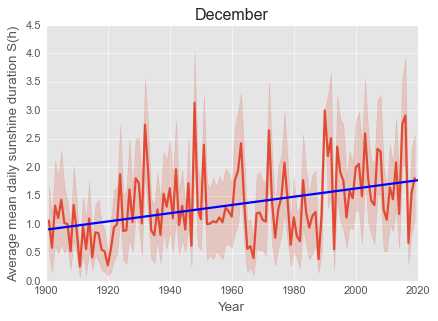

In [243]:
plt.figure(figsize=(6, 4))


chart = sns.lineplot(x="Year", y="Sunshine duration", data=mdf[mdf['Month']==12], 
                      markers=True)
chart.set(title='December', ylabel='Average mean daily sunshine duration S(h)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==12]['Year'], mdf[mdf['Month']==12]['Sunshine duration'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("s12.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

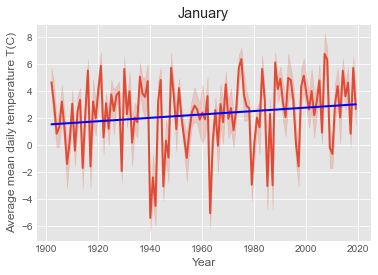

In [81]:
plt.figure(figsize=(6, 4))
plt.style.use('ggplot')

chart = sns.lineplot(x="Year", y="24-hour average temperature", data=mdf[mdf['Month']==1], 
                      markers=True)
chart.set(title='January', ylabel='Average mean daily temperature T(C)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==1]['Year'], mdf[mdf['Month']==1]['24-hour average temperature'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("t1.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

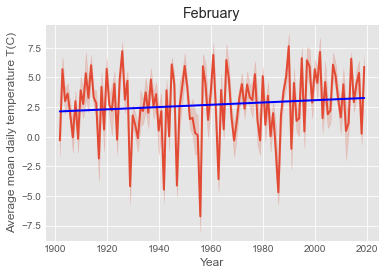

In [82]:
plt.figure(figsize=(6, 4))

chart = sns.lineplot(x="Year", y="24-hour average temperature", data=mdf[mdf['Month']==2], 
                      markers=True)
chart.set(title='February', ylabel='Average mean daily temperature T(C)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==2]['Year'], mdf[mdf['Month']==2]['24-hour average temperature'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("t2.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

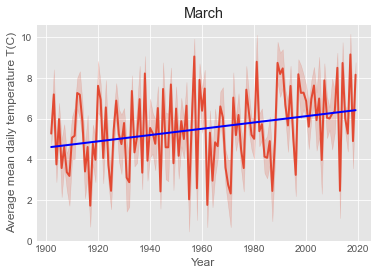

In [83]:
plt.figure(figsize=(6, 4))


chart = sns.lineplot(x="Year", y="24-hour average temperature", data=mdf[mdf['Month']==3], 
                      markers=True)
chart.set(title='March', ylabel='Average mean daily temperature T(C)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==3]['Year'], mdf[mdf['Month']==3]['24-hour average temperature'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("t3.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

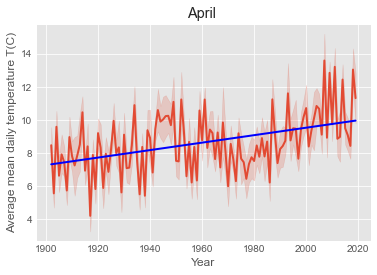

In [84]:
plt.figure(figsize=(6, 4))


chart = sns.lineplot(x="Year", y="24-hour average temperature", data=mdf[mdf['Month']==4], 
                      markers=True)
chart.set(title='April ', ylabel='Average mean daily temperature T(C)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==4]['Year'], mdf[mdf['Month']==4]['24-hour average temperature'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("t4.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

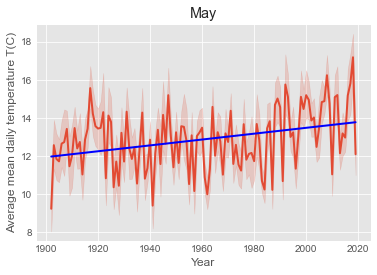

In [85]:
plt.figure(figsize=(6, 4))


chart = sns.lineplot(x="Year", y="24-hour average temperature", data=mdf[mdf['Month']==5], 
                      markers=True)
chart.set(title='May', ylabel='Average mean daily temperature T(C)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==5]['Year'], mdf[mdf['Month']==5]['24-hour average temperature'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("t5.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

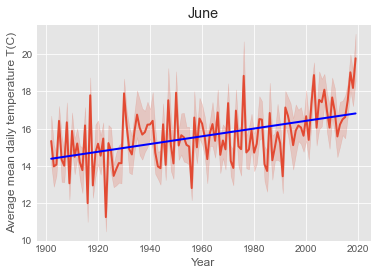

In [86]:
plt.figure(figsize=(6, 4))


chart = sns.lineplot(x="Year", y="24-hour average temperature", data=mdf[mdf['Month']==6], 
                      markers=True)
chart.set(title='June', ylabel='Average mean daily temperature T(C)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==6]['Year'], mdf[mdf['Month']==6]['24-hour average temperature'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("t6.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

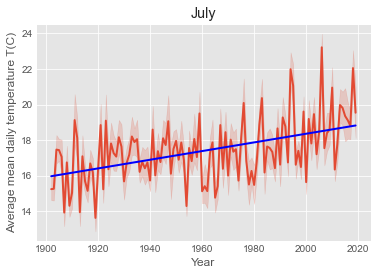

In [87]:
plt.figure(figsize=(6, 4))


chart = sns.lineplot(x="Year", y="24-hour average temperature", data=mdf[mdf['Month']==7], 
                      markers=True)
chart.set(title='July', ylabel='Average mean daily temperature T(C)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==7]['Year'], mdf[mdf['Month']==7]['24-hour average temperature'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("t7.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

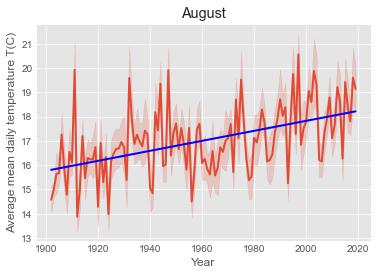

In [88]:
plt.figure(figsize=(6, 4))


chart = sns.lineplot(x="Year", y="24-hour average temperature", data=mdf[mdf['Month']==8], 
                      markers=True)
chart.set(title='August', ylabel='Average mean daily temperature T(C)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==8]['Year'], mdf[mdf['Month']==8]['24-hour average temperature'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("t8.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

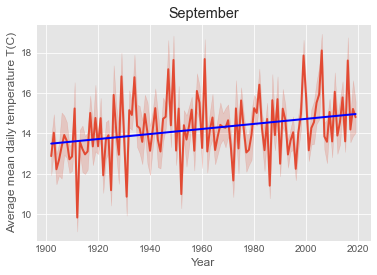

In [89]:
plt.figure(figsize=(6, 4))

chart = sns.lineplot(x="Year", y="24-hour average temperature", data=mdf[mdf['Month']==9], 
                      markers=True)
chart.set(title='September', ylabel='Average mean daily temperature T(C)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==9]['Year'], mdf[mdf['Month']==9]['24-hour average temperature'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("t9.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

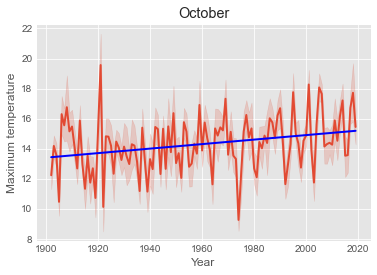

In [90]:
plt.figure(figsize=(6, 4))
plt.style.use('ggplot')

chart = sns.lineplot(x="Year", y="Maximum temperature", data=mdf[mdf['Month']==10], 
                      markers=True)
chart.set(title='October', ylabel='Maximum temperature', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==10]['Year'], mdf[mdf['Month']==10]['Maximum temperature'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("t10.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

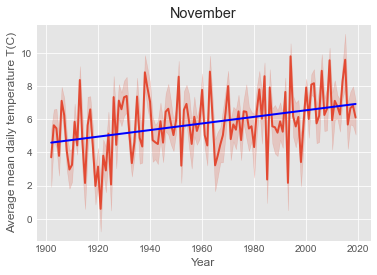

In [91]:
plt.figure(figsize=(6, 4))
plt.style.use('ggplot')

chart = sns.lineplot(x="Year", y="24-hour average temperature", data=mdf[mdf['Month']==11], 
                      markers=True)
chart.set(title='November', ylabel='Average mean daily temperature T(C)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==11]['Year'], mdf[mdf['Month']==11]['24-hour average temperature'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("t11.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

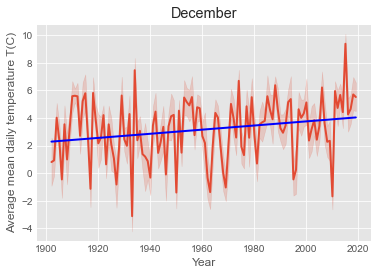

In [92]:
plt.figure(figsize=(6, 4))
plt.style.use('ggplot')

chart = sns.lineplot(x="Year", y="24-hour average temperature", data=mdf[mdf['Month']==12], 
                      markers=True)
chart.set(title='December', ylabel='Average mean daily temperature T(C)', xlabel="Year")

z = np.polyfit(mdf[mdf['Month']==12]['Year'], mdf[mdf['Month']==12]['24-hour average temperature'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("t12.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

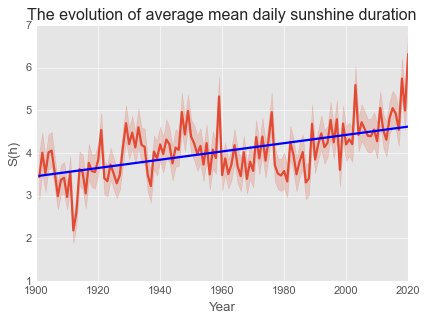

In [230]:
plt.figure(figsize=(6, 4))
plt.style.use('ggplot')

chart = sns.lineplot(x="Year", y="Sunshine duration", data=mdf, 
                      markers=True)
chart.set(title='The evolution of average mean daily sunshine duration', ylabel='S(h)', xlabel="Year")

z = np.polyfit(mdf['Year'], mdf['Sunshine duration'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("suntot.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)

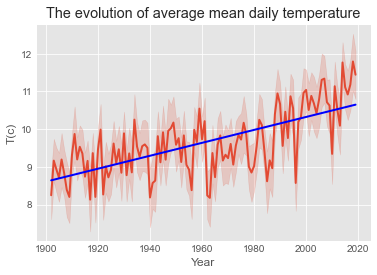

In [79]:
plt.figure(figsize=(6, 4))
plt.style.use('ggplot')

chart = sns.lineplot(x="Year", y="24-hour average temperature", data=mdf, 
                      markers=True)
chart.set(title='The evolution of average mean daily temperature', ylabel='T(c)', xlabel="Year")

z = np.polyfit(mdf['Year'], mdf['24-hour average temperature'], 1)
p = np.poly1d(z)

plt.plot(mdf['Year'], p(mdf['Year']), c="b", ls="-")
plt.savefig("ttot.jpeg",bbox_inches="tight",pad_inches = 0,dpi=700)